## Инсталлы и импорты

In [2]:
%%capture
!pip install torch 
!pip install torchvision
!pip install bing_image_downloader

In [3]:
import torchvision
import torch
import os
from PIL import Image
from pathlib import Path
from typing import Tuple, List, Dict
import numpy as np
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from transformers import  AutoModelForImageClassification
from torch.utils.data import DataLoader, Dataset

## Загрузка модели

In [5]:
model_name = "swueste/plant-health-image-classifier"
model = AutoModelForImageClassification.from_pretrained(model_name)

### Берем классы из лейблов модели

In [7]:
def find_classes(model):
    classes = []
    classes_to_idx = []
    classes_idx = []

    labels = model.config.id2label
    for i in range(len(labels)):
        classes_idx.append(i)
        classes.append(labels[i])
        classes_to_idx.append([labels[i], i])
    classes_to_idx = dict(classes_to_idx)
    return classes, classes_to_idx, classes_idx

In [8]:
classes, classes_to_idx, classes_idx = find_classes(model)

In [9]:
classes

['healthy', 'mildew', 'spots']

## Скачиваем картинки по классам

In [11]:
folder_path = 'D:\\studying\\IKBFU\\ds\\datasets\\diseases2\\'
query_str = " plant leaves photo jpg"

In [12]:
from bing_image_downloader import downloader
for class_name in classes:
    downloader.download(class_name + query_str, limit=30,  output_dir=folder_path,
                        force_replace=False, timeout=60)

[%] Downloading Images to D:\studying\IKBFU\ds\datasets\diseases2\healthy plant leaves photo jpg


[!!]Indexing page: 1

[%] Indexed 30 Images on Page 1.


[%] Downloading Image #1 from https://thumbs.dreamstime.com/z/bright-green-healthy-leaves-hosta-plants-other-varieties-used-as-ground-cover-many-backyard-gardens-several-large-136393787.jpg
[%] File Downloaded !

[%] Downloading Image #2 from https://c8.alamy.com/comp/S3FDWY/healthy-green-leaves-of-a-tomato-plant-in-spring-S3FDWY.jpg
[%] File Downloaded !

[%] Downloading Image #3 from https://thumbs.dreamstime.com/z/healthy-leaves-4601168.jpg
[%] File Downloaded !

[%] Downloading Image #4 from https://static.pexels.com/photos/73986/green-nature-leaf-73986.jpeg
[!] Issue getting: https://static.pexels.com/photos/73986/green-nature-leaf-73986.jpeg
[!] Error:: IncompleteRead(1587342 bytes read, 10590 more expected)
[%] Downloading Image #4 from https://images.pexels.com/photos/57726/leaf-leaves-jack-fruit-leaf-green-57726.jpeg?cs=srg

## Переименовываем папки, чтоб они соответствовали названию класса

In [14]:
subfolders = [f for f in os.listdir(folder_path) if os.path.isdir(os.path.join(folder_path, f))]

for subfolder in subfolders:
    old_path = os.path.join(folder_path, subfolder)
    new_path = os.path.join(folder_path, subfolder[:len(subfolder)-len(query_str)])
    os.rename(old_path, new_path)

print("Все подпапки переименованы!")

Все подпапки переименованы!


## Кастомный класс для загрузки датасета

In [16]:
class ImageFolderCustom(Dataset):
    def __init__(self, targ_dir: str, model, transform=None) -> None:
        self.paths = list(Path(targ_dir).glob("*/*.jpg")) + list(Path(targ_dir).glob("*/*.jpeg"))
        self.transform = transform
        self.classes, self.class_to_idx, self.classes_idx = find_classes(model)

    def load_image(self, index: int) -> Image.Image:
        image_path = self.paths[index]
        return Image.open(image_path) 
    
    def __len__(self) -> int:
        return len(self.paths)
    
    def __getitem__(self, index: int) -> Tuple[torch.Tensor, int]:
        img = self.load_image(index)
        class_name  = self.paths[index].parent.name
        class_idx = self.class_to_idx[class_name]

        if self.transform:
            return self.transform(img), class_idx
        else:
            return img, class_idx

In [19]:
ds_transforms = torchvision.transforms.Compose([
    torchvision.transforms.Resize((224, 224)),
    torchvision.transforms.ToTensor()
])

In [21]:
dataset = ImageFolderCustom(targ_dir = folder_path, model = model,
                           transform = ds_transforms)
test_dataloader = DataLoader(dataset, batch_size=1)

## Подсчитываем y_true и y_pred

In [24]:
model.eval()

y_true = []
y_pred = []
classes_conf_matr = []
with torch.no_grad():
    for batch in test_dataloader:
        inputs = batch[0]
        y_true.append(int(batch[1]))
        outputs = model(inputs)
        logits = outputs.logits
        y_pred.append(torch.argmax(logits, dim=-1).item())


## Визуализируем confusion matrix

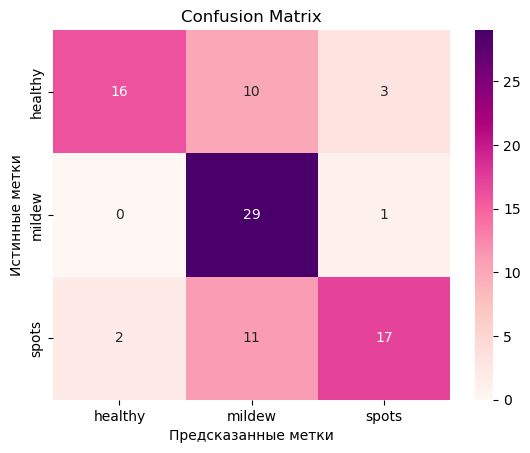

In [26]:
cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="RdPu", xticklabels=classes, yticklabels=classes)
plt.title("Confusion Matrix")
plt.xlabel("Предсказанные метки")
plt.ylabel("Истинные метки")
plt.show()